Read time= 0.002591371536254883 [sec.]


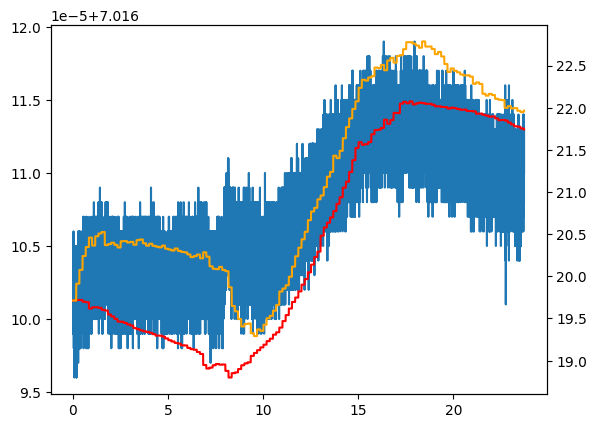

In [1]:
import time
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

import DMM6500

f_name='DMM6500vs_7Vref.pkl'
f_name='DMM6500vs_7Vref_14daysLater.pkl'
f_name='DMM6500vs_7Vref_TCVref21V.pkl'
f = DMM6500.fast_file()
df= pd.DataFrame([],columns=['time','V10','V7','Tamb','Tref'])
df = f.load(f_name)
dT = df.Tref[100] - df.Tamb[100]
T0 = df.time[0]
df.time = (df.time - T0)/3600
for i in range (len(df)):  #filter the bad samples
    if i>=1:
        if abs(df.V10[i]-df.V10[i-1])>2e-5:
            df.V10[i] = df.V10[i-1]        
#plt.plot(df.time,df.V7)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax3 = ax1.twinx()
ax1.plot(df.time[30:],df.V7[30:])
ax2.plot(df.time[30:],df.Tamb[30:], color='red')
ax2.plot(df.time[30:],df.Tref[30:]-dT, color='orange')
plt.show()

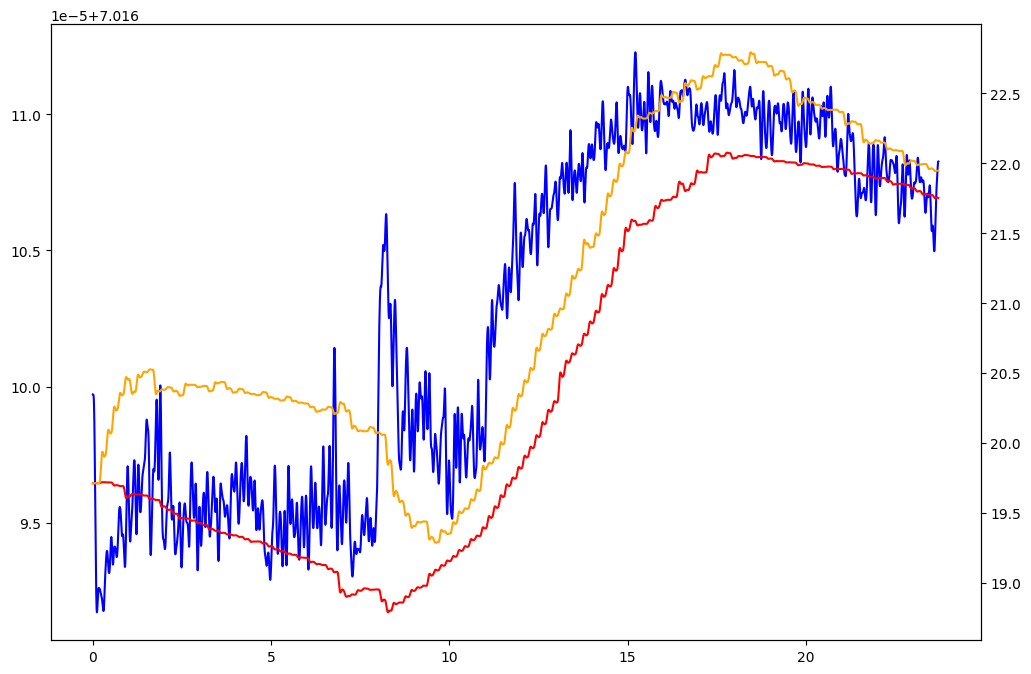

-------  corelation based on Tambient ---------------
Correlation Coefficient for 10V524: 0.24976655677105247
Correlation Coefficient for 7V015: 0.8773785090637275
-------  corelation based on Tref ---------------
Correlation Coefficient for 10V524: 0.09948706803867616
Correlation Coefficient for 7V015: 0.8644217319060222


In [5]:
#2 Calculte the both TC 7V and 10.524V
#  V7 is TC of DMM6500
#  V10 is the TC of HP34970
from scipy.signal import butter, lfilter, lfilter_zi
df['V10lpf'] = np.nan
df['V7lpf']  = np.nan
df['Tamblpf']  = np.nan
df['Treflpf']  = np.nan
b, a = butter(5, 0.005)
zi = lfilter_zi(b, a)
df.V7lpf, zo  = lfilter(b, a, df.V7, zi=zi*df.V7[0])
df.V10lpf, zo = lfilter(b, a, df.V10, zi=zi*df.V10[0])
df.Tamblpf,zo= lfilter(b, a, df.Tamb, zi=zi*df.Tamb[0])
df.Treflpf,zo= lfilter(b, a, df.Tref, zi=zi*df.Tref[0])

plt.rcParams['figure.figsize'] = [12, 8] 
fig2,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df.time,df.V7lpf,color='blue')
ax2.plot(df.time,df.Tamblpf, color='red')
ax2.plot(df.time,df.Treflpf-dT, color='orange')
plt.show(fig2)
corr_coefficient10 = df.V10.corr(df.Tamb)
corr_coefficient7  = df.V7.corr(df.Tamb)
print ('-------  corelation based on Tambient ---------------')
print("Correlation Coefficient for 10V524:", corr_coefficient10)
print("Correlation Coefficient for 7V015:", corr_coefficient7)
c10 = df.V10.corr(df.Tref)
c7  = df.V7.corr(df.Tref)
print ('-------  corelation based on Tref ---------------')
print("Correlation Coefficient for 10V524:", c10)
print("Correlation Coefficient for 7V015:", c7)

In [10]:
from sklearn.linear_model import LinearRegression
# Extract voltage and temperature data
voltage10 = df.V10.values.reshape(-1, 1)  # Reshape for sklearn
voltage7  = df.V7.values.reshape(-1, 1)  # Reshape for sklearn
temperature = df.Tamblpf.values.reshape(-1, 1)

# Fit linear regression model
model10 = LinearRegression().fit(temperature, voltage10)
model7  = LinearRegression().fit(temperature, voltage7)
# Get coefficient (temperature coefficient of voltage)
temperature_coefficient7  = model7.coef_[0][0]
temperature_coefficient10 = model10.coef_[0][0]
print("TC of 7V015:", temperature_coefficient7)
print("TC of 10V524:", temperature_coefficient10)


TC of 7V015: 3.1013129060645654e-06
TC of 10V524: 1.1702905188550238e-06


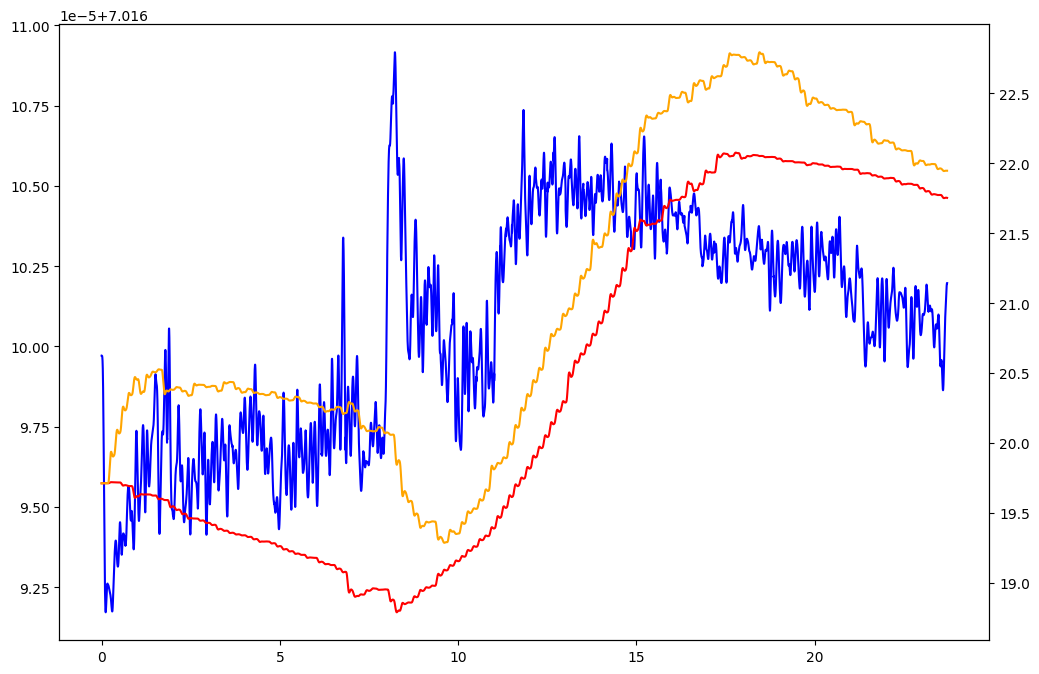

In [11]:
if corr_coefficient7>0.79:
    #perform TC compensation for 7V
    df['V7TC'] = np.nan
    df['V7TClpf'] = np.nan
    for i in range(len(df)):
        df.V7TC[i]    = df.V7[i] - temperature_coefficient7*(df.Tamb[i]-df.Tamb[0])
        df.V7TClpf[i] = df.V7lpf[i]-temperature_coefficient7*(df.Tamb[i]-df.Tamb[0])
    plt.rcParams['figure.figsize'] = [12, 8] 
    fig3,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(df.time,df.V7TClpf,color='blue')
    ax2.plot(df.time,df.Tamblpf, color='red')
    ax2.plot(df.time,df.Treflpf-dT, color='orange')
    plt.show(fig3)

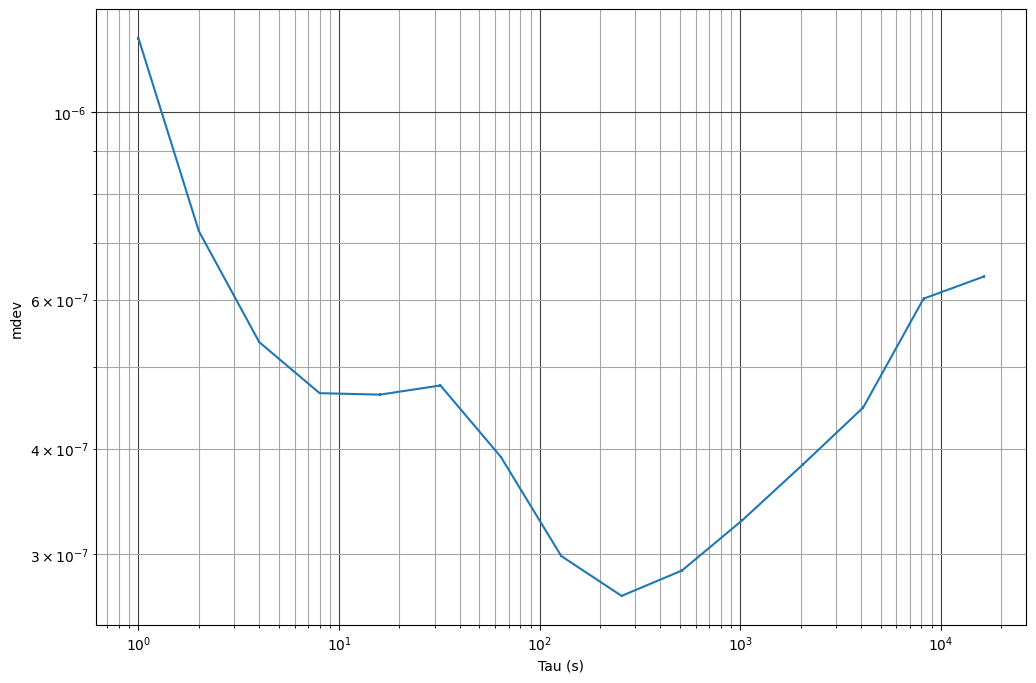

In [16]:
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
import math as m
import statistics as stat
import time
import allantools

if corr_coefficient7>0.79:
  a = allantools.Dataset(data=df.V7TC, rate=1.0, data_type='freq')
  a.compute("mdev")
  # New in 2019.7 : write results to file
  #a.write_result("output.dat")
  # Plot it using the Plot class
  b = allantools.Plot()
  # New in 2019.7 : additional keyword arguments are passed to
  # matplotlib.pyplot.plot()
  b.plot(a, errorbars=True, grid=True)
  # You can override defaults before "show" if needed
  b.ax.set_xlabel("Tau (s)")
  b.show()

In [56]:
b

array([9.09286611e-10, 4.54643306e-09, 9.09286611e-09, 9.09286611e-09,
       4.54643306e-09, 9.09286611e-10])